In [170]:
%load_ext autoreload
%autoreload 2
from causal_optoconnectics.core import (
    hit_rate, instrumental_connection_probability, 
    interventional_connection_probability, connection_probability_nonparametric,
    instrumental_connection_probability_nonparametric
)
from causal_optoconnectics.cch import fit_latency
from causal_optoconnectics.buzsaki import transfer_probability
import sys
sys.path.append('../..')
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import plot_xcorr, savefig, fix_figure, despine, set_style, response_plotter, regplot
from tools_analysis import corrcoef
import copy
from collections import defaultdict
from IPython.display import display
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

# Slow synapse parameters

In [2]:
# from params_AI import parameters
# sim = Simulator(parameters, fname='network-power', 
#                 stim_N=5000)
# sim.simulate(save=True, raster=False)
# data = sim.data
data = np.load('../../results/params_test.npz', allow_pickle=True)['data'][()]

# from params_SI import parameters
# sim = Simulator(parameters, fname='test_SI', data_path='results', 
#                 stim_N=100, stim_period=30, stim_dist='poisson', stim_amp_ex=10.0)
# sim.simulate(state=True, save=True, raster=True)

# data = sim.data

# data = np.load('results/params_SI.npz')['data'][()]

In [3]:
data['params']

{'C_ex': 320,
 'C_in': 80,
 'C_m': 250.0,
 'C_p': 400,
 'E_L': -70.0,
 'E_ex': 0.0,
 'E_in': -80.0,
 'I0': 10,
 'Imax': 642,
 'J_ex': 0.68,
 'J_high': 5.0,
 'J_in': -11.9,
 'J_low': 0.0,
 'K': 0.84,
 'NA': 0.37,
 'N_ex': 3200,
 'N_in': 800,
 'N_neurons': 4000,
 'N_pos': 100,
 'N_rec_spike_ex': None,
 'N_rec_spike_in': None,
 'N_rec_state_ex': None,
 'N_rec_state_in': None,
 'S': 10.3,
 'V_m': -70.0,
 'V_reset': -70.0,
 'V_th': -50.0,
 'data_path': 'results',
 'delay': 1.5,
 'density': 10490.761686802165,
 'depth': 0.7,
 'eps': 0.1,
 'eps_p': 0.1,
 'fname': 'params_test',
 'g': 2.5,
 'g_L': 16.7,
 'msd': 1234,
 'n': 1.36,
 'n_hill': 0.76,
 'num_threads': 4,
 'p_var': 0.1,
 'r': 0.1,
 'rate_ex': 1.7847401341499143,
 'rate_in': 1.587826883214396,
 'rate_p': 23.5,
 'res': 0.1,
 'status': {'time': 8000139.3},
 'stim_N_ex': 1000,
 'stim_N_in': 0,
 'stim_amp_ex': 400.0,
 'stim_amp_in': 0.0,
 'stim_dist': 'poisson',
 'stim_duration': 2.0,
 'stim_isi_min': 200.0,
 'stim_rate': 30.0,
 'stop_time

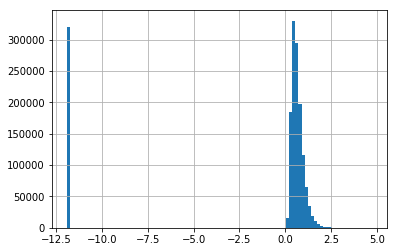

In [4]:
conn = data['connections']
conn.weight.hist(bins=100)

In [5]:
spiketrains = {
    s: {'pop': pop, 'times': val['times'][val['senders']==s] / 1000}
    for pop, val in data['spiketrains'].items()
    for s in sorted(np.unique(val['senders']))
}

In [6]:
data['epoch']['times'] /= 1000

In [7]:
# B = 1
# # Find A and D
# affectors = conn.loc[(conn.target==B) & (conn.weight > 0)]
# m1 = affectors.weight.max()
# D = affectors[affectors.weight==m1].source
# D = int(D)
# m2 = conn.loc[(conn.source==D) & (conn.weight!=m1)].weight.max()
# A_ = conn.loc[(conn.source==D) & (conn.weight==m2)].target
# A_ = int(A_)
# print(A_, D)

In [8]:
# A, B, C = 11, 94, 978 print(A,B,C)

In [9]:
names = ['A', 'B', 'C']

In [10]:
conn.loc[:,'source_stimulated'] = conn.source.isin(data['stim_nodes']['ex'])
conn.loc[:,'target_stimulated'] = conn.target.isin(data['stim_nodes']['ex'])

In [11]:
conn['stim_amp_source'] = conn.progress_apply(
    lambda x: data['stim_amps']['ex'].get(x.source, 0), axis=1)

In [20]:
As = conn.query("stim_amp_source == 400").sort_values('weight', ascending=False).iloc[3]
A = As.source
C = As.target

Bs = conn.query("source!={A} and target!={C} and stim_amp_source == 400".format(A=A, C=C))
B = Bs.source.iloc[2]

In [21]:
if A in set(conn.loc[conn.source==B].target): 
    weight = conn.loc[(conn.source==B) & (conn.target==A)].weight.sum()
    print('A is targeted by B, w = {:.4f}'.format(weight))
if A in set(conn.loc[conn.source==C].target): 
    print('A is targeted by C')
if B in set(conn.loc[conn.source==A].target): 
    print('B is targeted by A')
if B in set(conn.loc[conn.source==C].target): 
    print('B is targeted by C')
if C in set(conn.loc[conn.source==A].target): 
    weight = conn.loc[(conn.source==A) & (conn.target==C)].weight.sum()
    print('C is targeted by A, w = {:.4f}'.format(weight))
if C not in set(conn.loc[conn.source==B].target): 
    print('C is not targeted by B')
if C in set(conn.loc[conn.source==B].target): 
    weight = conn.loc[(conn.source==B) & (conn.target==C)].weight.sum()
    print('C is targeted by B, w = {:.4f}'.format(weight))

C is targeted by A, w = 2.0038
C is not targeted by B


In [22]:
t_stop = data['params']['status']['time'] / 1000
t_stop

8000.1393

In [23]:
cc = corrcoef(
    [spiketrains[A]['times'], spiketrains[B]['times'], spiketrains[C]['times']], 
    t_stop=t_stop, binsize=4e-3)
pd.DataFrame(cc, index=names, columns=names)

,A,B,C
A,1.000000,0.268623,0.039798
B,0.268623,1.000000,0.038023
C,0.039798,0.038023,1.000000


(0.0026179531372880318, 0.0006628912819619266)

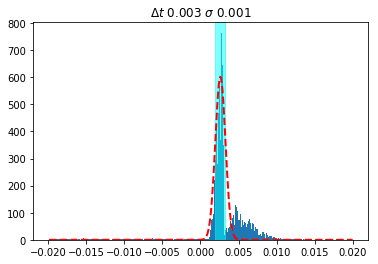

In [24]:
fit_latency(data['epoch']['times'], spiketrains[B]['times'], plot=True)

(0.0064472901096173825, 0.0019010464327185457)

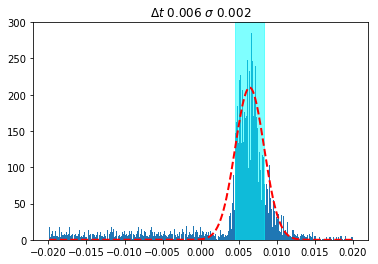

In [25]:
fit_latency(data['epoch']['times'], spiketrains[C]['times'], plot=True)

(0.0032099384642175614, 0.002969388739794898)

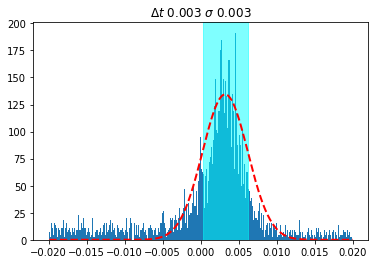

In [26]:
fit_latency(spiketrains[B]['times'], spiketrains[C]['times'], plot=True)

In [31]:
iv_params = {
#     'x_mu': 2e-3,
#     'x_sigma': 1e-3,
#     'y_mu': 5.8e-3,
#     'y_sigma': 1e-3,
#     'n_bases': 20,
#     'bin_size': 1e-4,
#     'offset': 1e-4,
#     'cutoff': 10e-3
}

trans_prob_params = {
    'y_mu': 4e-3,
    'y_sigma': 1e-3,
    'bin_size': 1e-3,
    'limit': 15e-3,
    'hollow_fraction': .8,
    'width': 100
}

In [32]:
ivb = single_stim_connection_probability(
    spiketrains[B]['times'], spiketrains[C]['times'], data['epoch']['times'], **iv_params)
ivb

0.07435752998380772

In [33]:
trb = transfer_probability(
    spiketrains[B]['times'], spiketrains[C]['times'], **trans_prob_params)[0]
trb

0.030293227923424548

In [51]:
rp_params = {
    'x_mu': 2e-3,
    'x_sigma': 1.5e-3,
    'y_mu': 5.8e-3,
    'y_sigma': 1e-3,
}
rpb = response_plotter(
    spiketrains[B]['times'], spiketrains[C]['times'], data['epoch']['times'], **rp_params)

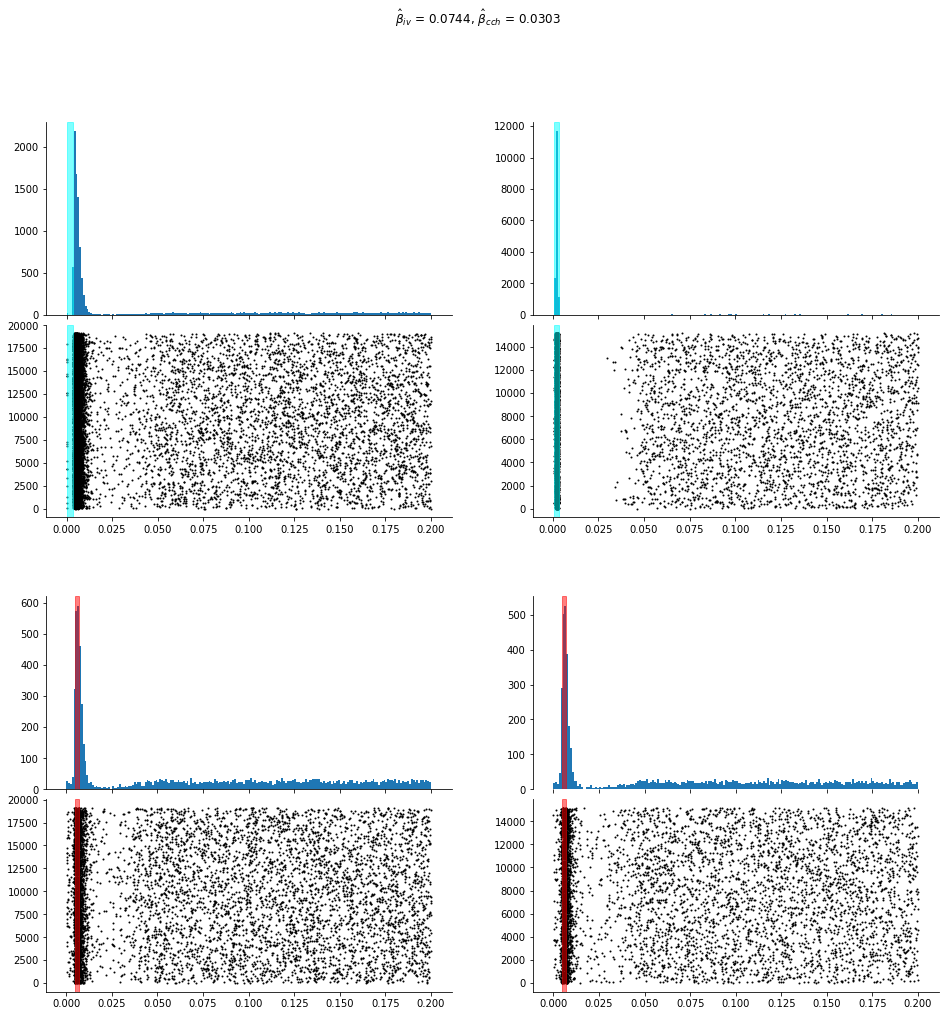

In [52]:
fig = plt.figure(figsize=(16,16))
gs = GridSpec(2, 2)
for i, idxs in enumerate([rpb.z0, rpb.z1]):
    rpb.plot('source', idxs, gs=gs[0, i])
    rpb.plot('target', idxs, gs=gs[1, i])
plt.suptitle('$\\hat\\beta_{{iv}}$ = {:.4f}, $\\hat\\beta_{{cch}}$ = {:.4f}'.format(ivb, trb));

(0.002622209926392629, 0.0006176556523743194)

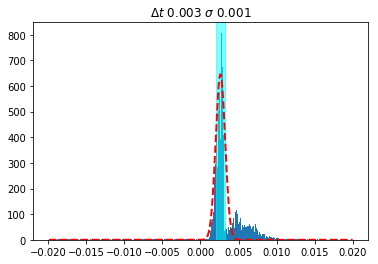

In [39]:
fit_latency(data['epoch']['times'], spiketrains[A]['times'], plot=True)

(0.0064472901096173825, 0.0019010464327185457)

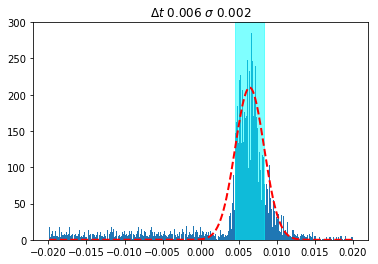

In [40]:
fit_latency(data['epoch']['times'], spiketrains[C]['times'], plot=True)

(0.00332283783973374, 0.002480951852126202)

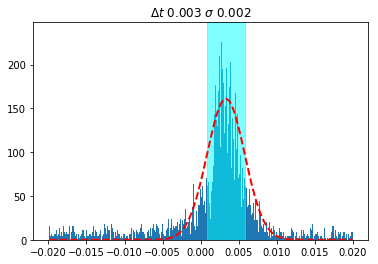

In [41]:
fit_latency(spiketrains[A]['times'], spiketrains[C]['times'], plot=True)

In [43]:
iva = single_stim_connection_probability(
    spiketrains[A]['times'], spiketrains[C]['times'], data['epoch']['times'], **iv_params)
iva

0.08787315226197875

In [44]:
tra = transfer_probability(
    spiketrains[A]['times'], spiketrains[C]['times'], **trans_prob_params)[0]
tra

0.04239352930008107

In [53]:
rpa = response_plotter(
    spiketrains[A]['times'], spiketrains[C]['times'], data['epoch']['times'], **rp_params)

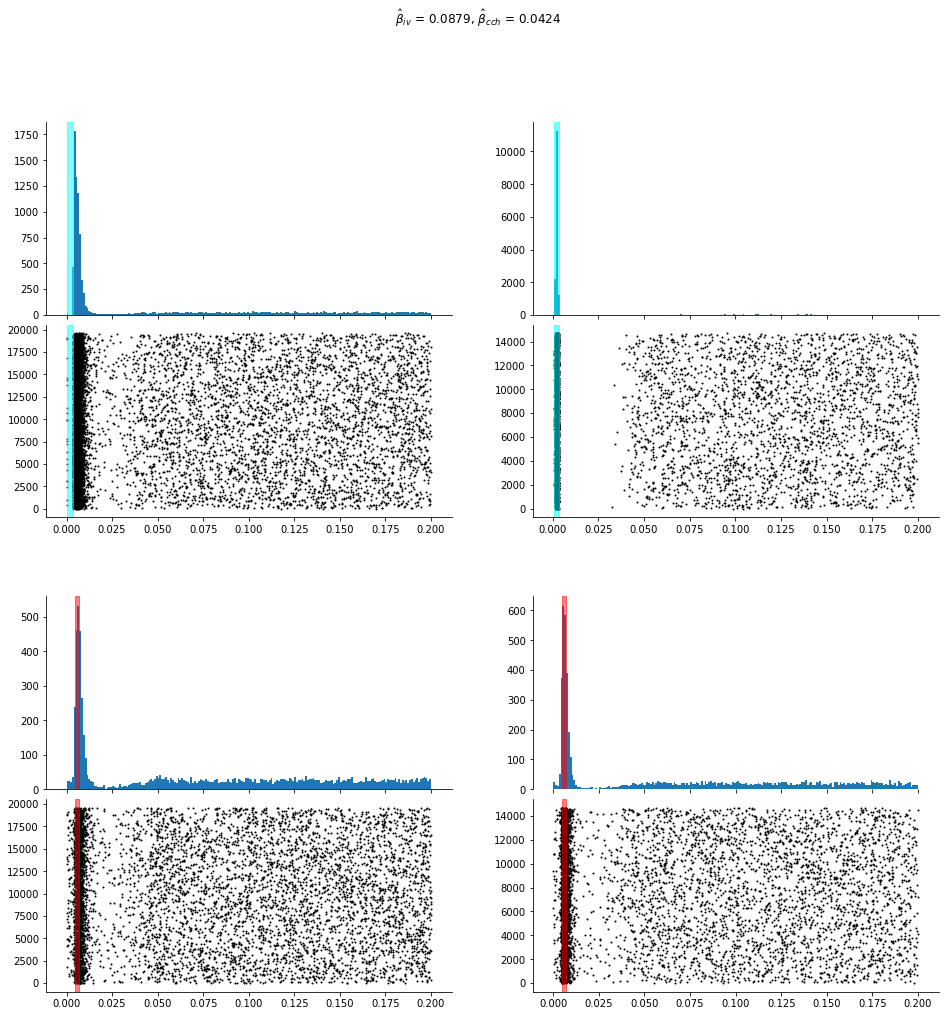

In [54]:
fig = plt.figure(figsize=(16,16))
gs = GridSpec(2, 2)
for i, idxs in enumerate([rpa.z0, rpa.z1]):
    rpa.plot('source', idxs, gs=gs[0, i])
    rpa.plot('target', idxs, gs=gs[1, i])
plt.suptitle('$\\hat\\beta_{{iv}}$ = {:.4f}, $\\hat\\beta_{{cch}}$ = {:.4f}'.format(iva, tra));

# performance

In [330]:
def post_stim(x, stim_times, mu, sigma):
    """Makes binary classification of response in windows"""
    stim_times = stim_times.astype(float)
    src_x = np.searchsorted(x, stim_times, side='right')
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    X = x[src_x] - stim_times
    return ((X > mu - sigma) & (X < mu + sigma)).astype(int)


def wald(source, target, stim_times, x_mu, x_sigma, y_mu, y_sigma):
    """The IV estimator used in the paper"""
    stim_response = post_stim(source, stim_times, x_mu, x_sigma)
    syn_response = post_stim(target, stim_times, y_mu, y_sigma)
    n = np.minimum(len(stim_response), len(syn_response))
    stim_response, syn_response = stim_response[:n], syn_response[:n]
    z_s1_x0 = stim_response == 0
    z_s1_x1 = stim_response == 1
    
    y_s1_x0 = syn_response[z_s1_x0]
    y_s1_x1 = syn_response[z_s1_x1]
    
#     y_s1 = (y_s1_x1.mean() - y_s1_x0.mean())
    y_s1 = (y_s1_x1.mean() - y_s1_x0.mean()) / (z_s1_x1.mean() - z_s1_x0.mean())
#     y_s1 = (y_s1_x1.mean() - y_s1_x0.mean()) / z_s1_x1.mean()
    
    return y_s1

In [913]:
wald_params = {
    'x_mu': 2e-3,
    'x_sigma': 1e-3,
    'y_mu': 6.4e-3,
    'y_sigma': 2e-3,
}

iv_params = {
    'x_mu': 2e-3,
    'x_sigma': 2e-3,
    'y_mu': 5e-3,
    'y_sigma': 5e-3,
    'n_bases': 20,
    'bin_size': 1e-4,
    'offset': 1e-4,
#     'cutoff': 10e-3
}

In [914]:
# causal_connectivity = single_stim_connection_probability
# causal_connectivity = interventional_connection_probability
# causal_connectivity = instrumental_connection_probability_nonparametric
# causal_connectivity = instrumental_connection_probability

In [915]:
from causal_optoconnectics.core import calculate_regressors, raised_cosine
from causal_optoconnectics.tools import histogram 
from sklearn.linear_model import LogisticRegression

# def causal_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, n_bases, bin_size, offset):
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)

#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

#     Z = abs(Z)
    
#     cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
    
#     model1 = LogisticRegression(C=1e5, solver='liblinear')#, penalty='none')
#     model1.fit(Z, X)

#     X_hat = model1.predict(Z)

#     model = LogisticRegression(C=1e5, solver='liblinear')#, penalty='none')
#     model.fit(X_hat.reshape(-1, 1), Y)
#     #
#     beta = model.predict_proba([[1], [0]])[:,0]

#     return float(np.diff(beta))



# import statsmodels.api as sm
# from linearmodels.iv import IV2SLS

# def causal_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
#     n_bases=20, bin_size=1e-3, offset=1e-2, cutoff=None):
    
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
# #     Z = abs(Z)
# #     if cutoff is None:
# #         cutoff = Z.max()

# #     time, bases, centers = raised_cosine(
# #         n_bases, bin_size, np.array([0, cutoff]), offset)

# #     def index(t, bin_size):
# #         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
# #     idxs = index(Z, bin_size)
# #     Z = bases[idxs,:]

    
#     X = ((X > x_mu - x_sigma) & (X < x_mu + x_sigma)).astype(int)
#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)
    
# #     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
#     X = np.vstack((X, np.ones(X.shape[0]))).T

# #     model = IV2SLS(dependent=Y, exog=None, endog=X, instruments=Z)
#     model = IV2SLS(dependent=Y, exog=X, endog=None, instruments=None)
#     try:
#         res = model.fit()
#         beta = res.params[0]
#     except:
#         beta = np.nan
#     return beta


# def causal_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
#     n_bases, bin_size, offset):
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)

#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

#     Z = abs(Z)
    
#     cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
    
#     model = sm.OLS(endog=X, exog=Z)
#     res = model.fit()
    
#     X_hat = np.vstack([X, res.resid]).T
    
#     model = LogisticRegression(C=1e5, solver='liblinear')
#     model.fit(X_hat, Y)

#     delta_1, (alpha_1, theta_1) = model.intercept_, model.coef_[0]
#     logit = lambda x: 1 / (1 + np.exp(-x))
#     delta, alpha = np.array([delta_1, alpha_1]) / np.sqrt(1 + theta_1**2 * np.var(res.resid))

#     return float(logit(delta + alpha * x_mu) - logit(delta + alpha * x_mu*10))

# def causal_connectivity(
#     x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
#     n_bases, bin_size, offset):
#     Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)

#     Y = ((Y > y_mu - y_sigma) & (Y < y_mu + y_sigma)).astype(int)

#     Z = abs(Z)
    
#     cutoff = Z.max()

#     time, bases, centers = raised_cosine(
#         n_bases, bin_size, np.array([0, cutoff]), offset)

#     def index(t, bin_size):
#         return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
#     idxs = index(Z, bin_size)
#     Z = bases[idxs,:]
    
#     model1 = sm.OLS(endog=X, exog=Z)
#     res1 = model1.fit()
    
#     X_hat = sm.add_constant(res1.fittedvalues)
    
#     model2 = sm.OLS(endog=Y, exog=X_hat)
#     res2 = model2.fit()

#     return res2.params[1]

def causal_connectivity(
    x, y, stim_times, x_mu, x_sigma, y_mu, y_sigma, 
    n_bases, bin_size, offset):

    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times

    stim_win = np.insert(
        stim_times + y_mu - y_sigma,
        np.arange(len(stim_times)) + 1,
        stim_times + y_mu + y_sigma)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    
    Z = abs(Z)
    
    cutoff = Z.max()

    time, bases, centers = raised_cosine(
        n_bases, bin_size, np.array([0, cutoff]), offset)

    def index(t, bin_size):
        return np.minimum(np.ceil(t / bin_size).astype(int), len(time)-1)
    
    idxs = index(Z, bin_size)
    Z = bases[idxs,:]
    
    model1 = sm.OLS(endog=X, exog=Z)
    res1 = model1.fit()
    
    X_hat = sm.add_constant(res1.fittedvalues)
    model2 = sm.OLS(endog=Y, exog=X_hat)
    res2 = model2.fit()
    beta = res2.params[1]

    return beta

In [942]:
iv_params = {
    'x_mu': 2e-3,
    'x_sigma': 2e-3,
    'y_mu': 6.5e-3,
    'y_sigma': 3e-3,
    'n_bases': 200,
    'bin_size': 1e-5,
    'offset': 1e-4,
#     'cutoff': 10e-3
}

In [943]:
causal_connectivity(
            spiketrains[A]['times'], spiketrains[C]['times'], data['epoch']['times'],
            **iv_params)

0.004820389608501433

In [944]:
causal_connectivity(
            spiketrains[B]['times'], spiketrains[C]['times'], data['epoch']['times'],
            **iv_params)

0.003174437552224839

In [945]:
causal_connectivity(
            spiketrains[A]['times'], spiketrains[C]['times'], data['epoch']['times'] - 100e-3,
            **iv_params)

0.03435592614477965

In [505]:
def validate_instrument(x, y, stim_times):
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    src_y = np.searchsorted(y, stim_times, side='right')

    remove_idxs, = np.where(
        (src_x==len(x)) | (src_x==0) | (src_y==len(y)) | (src_y==0))
    src_x = np.delete(src_x, remove_idxs)
    src_y = np.delete(src_y, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)

    X = x[src_x-1] - stim_times
    Y = y[src_y-1] - stim_times

    return X, Y

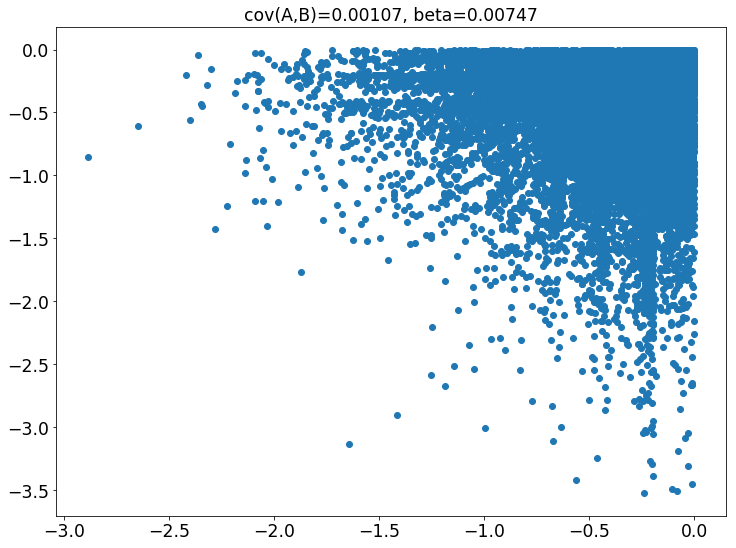

In [506]:
A_prestim, B_prestim = validate_instrument(
    spiketrains[A]['times'], spiketrains[B]['times'], data['epoch']['times'])

plt.scatter(A_prestim, B_prestim)
plt.title(
    'cov(A,B)={:.5f}, beta={:.5f}'.format(
        np.cov(A_prestim, B_prestim)[0,1], 
        np.corrcoef(A_prestim, B_prestim)[0,1] * A_prestim.std() / B_prestim.std()));

In [919]:
results = {'A': defaultdict(list), 'B': defaultdict(list)}
N_trials = [1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000, 30000, len(data['epoch']['times'])]
for N in tqdm(N_trials):
    for name, num in zip(['A', 'B'], [A, B]):
        iv = causal_connectivity(
            spiketrains[num]['times'], spiketrains[C]['times'], data['epoch']['times'][:N],
            **iv_params)
        results[name]['iv'].append(iv)
        iv_baseline = causal_connectivity(
            spiketrains[num]['times'], spiketrains[C]['times'], data['epoch']['times'][:N] - 70e-3,
            **iv_params)
        results[name]['iv_baseline'].append(iv_baseline)
        _hit_rate = hit_rate(
            spiketrains[num]['times'], data['epoch']['times'][:N], 
            wald_params['x_mu'], wald_params['x_sigma'])
        _wald = wald(
            spiketrains[num]['times'], spiketrains[C]['times'], data['epoch']['times'][:N],**wald_params)
        results[name]['wald'].append(_wald)
        results[name]['hit_rate'].append(_hit_rate)
results = {k:{l: np.array(v) for l, v in s.items()} for k, s in results.items()}

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

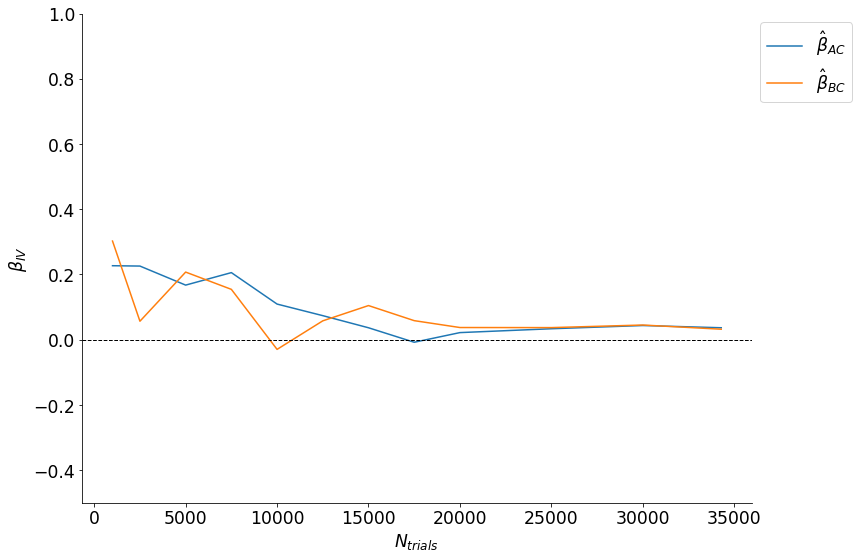

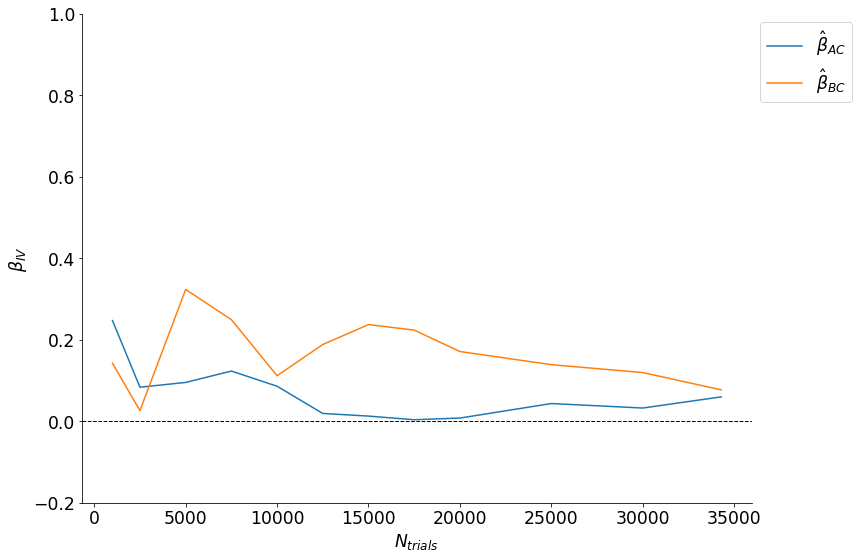

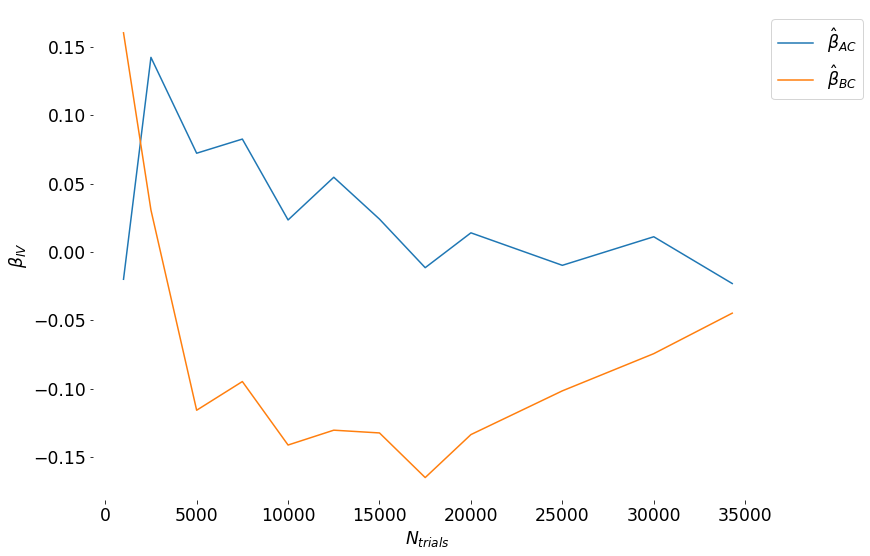

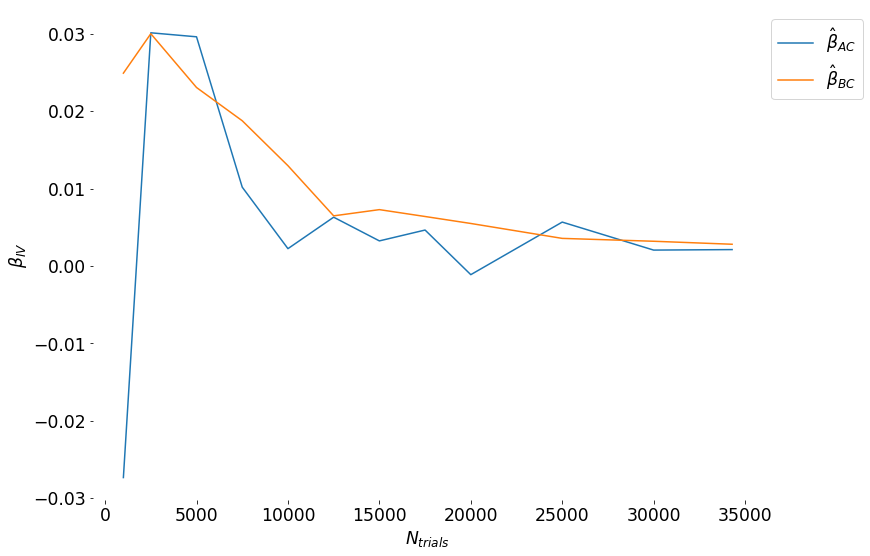

In [920]:
plt.figure()
plt.plot(N_trials, results['A']['iv'], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, results['B']['iv'], label='$\\hat\\beta_{BC}$')
plt.axhline(c='k', lw=1, ls='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('$\\beta_{IV}$')
sns.despine()
plt.ylim(-.5, 1)
# fix_figure()

plt.figure()
plt.plot(N_trials, results['A']['iv'] - results['A']['iv_baseline'], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, results['B']['iv'] - results['B']['iv_baseline'], label='$\\hat\\beta_{BC}$')
plt.axhline(c='k', lw=1, ls='--')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('$\\beta_{IV}$')
sns.despine()
plt.ylim(-.2, 1)

plt.figure()
plt.plot(N_trials, results['A']['iv_baseline'], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, results['B']['iv_baseline'], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('$\\beta_{IV}$')
sns.despine(bottom=True, left=True)

plt.figure()
plt.plot(N_trials, results['A']['wald'], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, results['B']['wald'], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('$\\beta_{IV}$')
sns.despine(bottom=True, left=True)

# multiple neurons

In [921]:
iv_params = {
    'x_mu': 2e-3,
    'x_sigma': 1e-3,
    'y_mu': 5e-3,
    'y_sigma': 5e-3,
    'n_bases': 20,
    'bin_size': 1e-4,
    'offset': 1e-3,
#     'cutoff': 2e-3
}

# causal_connectivity = instrumental_connection_probability
# causal_connectivity = interventional_connection_probability
# causal_connectivity = connection_probability_nonparametric
# causal_connectivity = instrumental_connection_probability_nonparametric

In [922]:
N=50
# trials = [len(data['epoch']['times'])]

# sample = conn.query('stim_amp_source > 200 and weight > 0 and not target_stimulated').sample(n=int(N / 2))
# print(sample.weight.max())

In [923]:
sources, targets = sample.loc[:, ['source', 'target']].to_numpy().T

assert len(sources) + len(targets) == N

results_mn = defaultdict(list)
pbar = tqdm(total=int(N / 2)**2 * len(trials))
for N_trials in trials:
    stim_times = data['epoch']['times'][:N_trials + 1]
    period = np.min(np.diff(stim_times))
    t_stop = stim_times[-1] + period
    for source in sources:
        for target in targets: #NOTE different latency in inhibitory neurons
            if target == source:
                continue
            pbar.update(1)
            source_t = spiketrains[source]['times']
            target_t = spiketrains[target]['times']
            source_t, target_t = source_t[source_t <= t_stop], target_t[target_t <= t_stop]
            iv = causal_connectivity(
                source_t, target_t, stim_times, **iv_params)
            iv_baseline = causal_connectivity(
                source_t, target_t, stim_times - 50e-3, **iv_params)
        
            stim_amp = float(data['stim_amps']['ex'][source])
            # cc, cv and stuff
            w = conn.query("source=={} and target=={}".format(source, target)).weight
            n_syn = len(w)
#             _hit_rate = hit_rate(
#                 source_t, stim_times, wald_params['x_mu'], wald_params['x_sigma'])
#             _wald = wald(
#                 source_t, target_t, stim_times, **wald_params)
            results_mn['iv'].append(iv)
            results_mn['iv_baseline'].append(iv_baseline)
            results_mn['weight'].append(w.sum())
            results_mn['stim_amp'].append(stim_amp)
#             results_mn['hit_rate'].append(_hit_rate)
#             results_mn['wald'].append(_wald)
            results_mn['source'].append(source)
            results_mn['target'].append(target)
            results_mn['n_syn'].append(n_syn)
pbar.close()
results_mn = pd.DataFrame(results_mn)

HBox(children=(IntProgress(value=0, max=625), HTML(value='')))

In [482]:
As = results_mn.query('weight > .5 and weight < 1').sort_values('iv')
As

i = 0
A, C = As.iloc[i].source, As.iloc[i].target
A, C

Bs = results_mn.query('target != {} and source != {} and weight == 0'.format(C, A)).sort_values('iv', ascending=False)
B = Bs.iloc[0].source

In [887]:
results_mn['iv_baseline'] = results_mn.apply(lambda x: float(x.iv_baseline), axis=1)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'LPM')

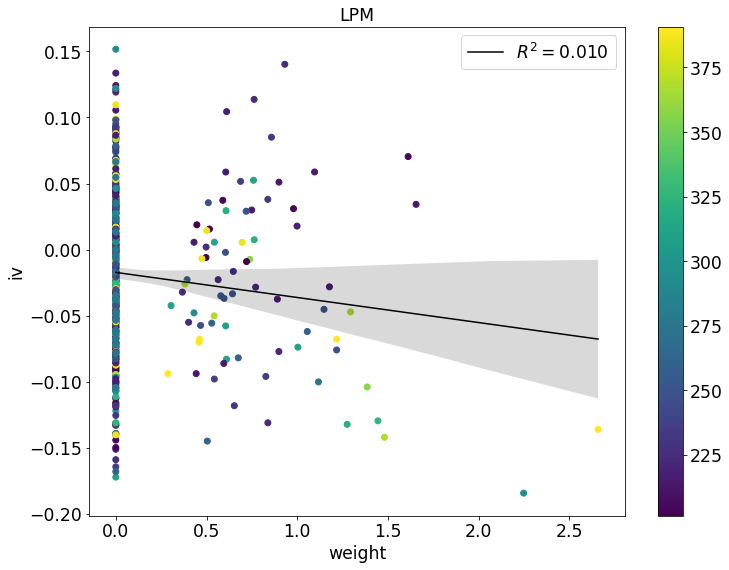

In [924]:
model = regplot(
    'weight', 'iv', data=results_mn, 
    scatter_color=results_mn_query['stim_amp'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])
plt.title('LPM')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Baseline')

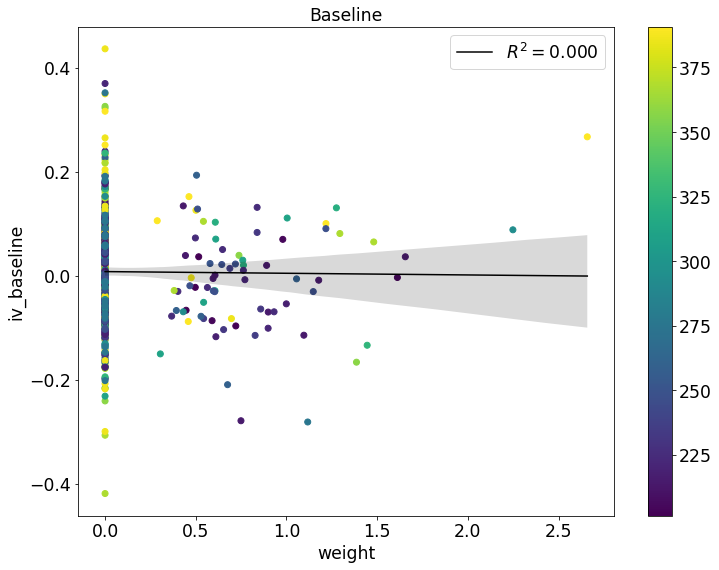

In [925]:
model = regplot(
    'weight', 'iv_baseline', data=results_mn, 
    scatter_color=results_mn_query['stim_amp'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])
plt.title('Baseline')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Corrected')

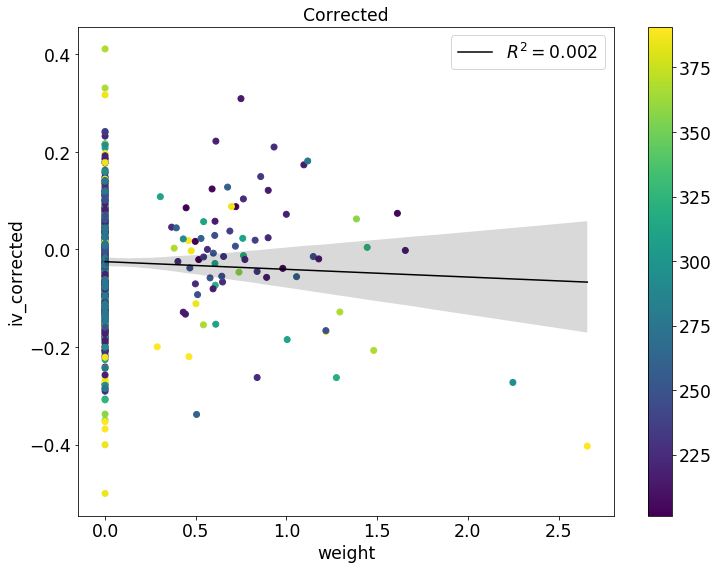

In [926]:
results_mn.loc[:,'iv_corrected'] = results_mn.iv - results_mn.iv_baseline
model = regplot(
    'weight', 'iv_corrected', data=results_mn, 
    scatter_color=results_mn_query['stim_amp'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])
plt.title('Corrected')

In [473]:
# model = regplot(
#     'weight', 'wald', data=results_mn, 
#     scatter_color=results_mn_query['stim_amp'], colorbar=True)

# h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
# plt.gca().legend(handles=[h])

# Transfer probability

In [185]:
trans_prob_params = {
    'y_mu': 4e-3,
    'y_sigma': 1e-3,
    'bin_size': 1e-3,
    'limit': 15e-3,
    'hollow_fraction': .6,
    'width': 60
}

In [186]:
results_tr = defaultdict(list)
N_trials = [1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000, 30000, len(data['epoch']['times'])]
for N in tqdm(N_trials):
    for name, num in zip(['A', 'B'], [A, B]):
        stop = data['epoch']['times'][N-1]
        mask1 = spiketrains[num]['times'] < stop
        mask2 = spiketrains[C]['times'] < stop
        tr = transfer_probability(
            spiketrains[num]['times'][mask1], spiketrains[C]['times'][mask2],
            **trans_prob_params)[0]
        results_tr[name].append(tr)
results_tr = pd.DataFrame(results_tr)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

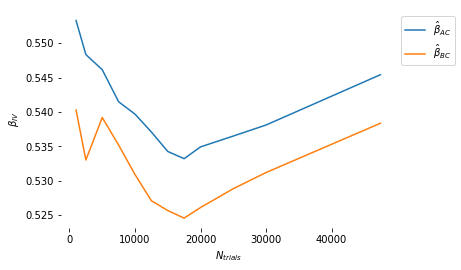

In [187]:
plt.figure()
plt.plot(N_trials, results_tr['A'], label='$\\hat\\beta_{AC}$')
plt.plot(N_trials, results_tr['B'], label='$\\hat\\beta_{BC}$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('$\\beta_{IV}$')
sns.despine(bottom=True, left=True)

# XCORR

In [20]:
set_style('notebook')
t_stop = data['params']['status']['time']
spiketrains_ABC = [spiketrains[idx]['times'] for idx in [A, B, C]]
names = ['A', 'B', 'C']
colors = sns.color_palette()

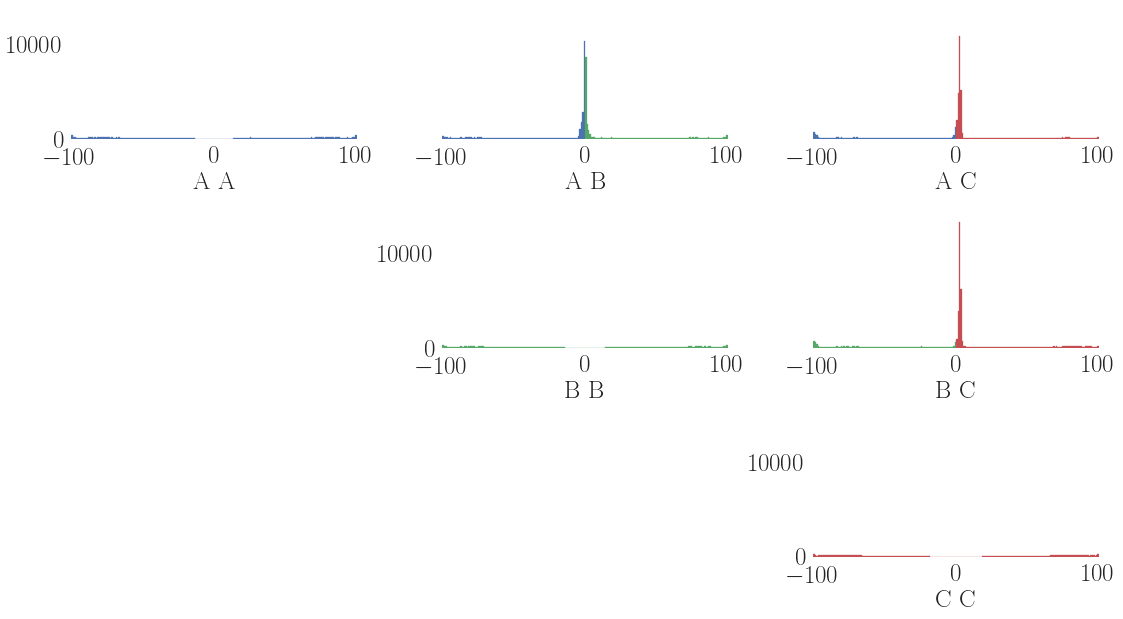

In [21]:
plot_xcorr(spiketrains_ABC, colors=colors, time_limit=100, binsize=1,
           xticksvisible=True, yticksvisible=False, density=False,
           names=names);
sns.despine(bottom=True, left=True)
fig = plt.gcf()
savefig(fig, 'xcorr_network')

In [22]:
from exana.statistics.tools import ccg_significance

time_limit = 30
binsize = 1
ylim = [0, 10000]


13251
10831


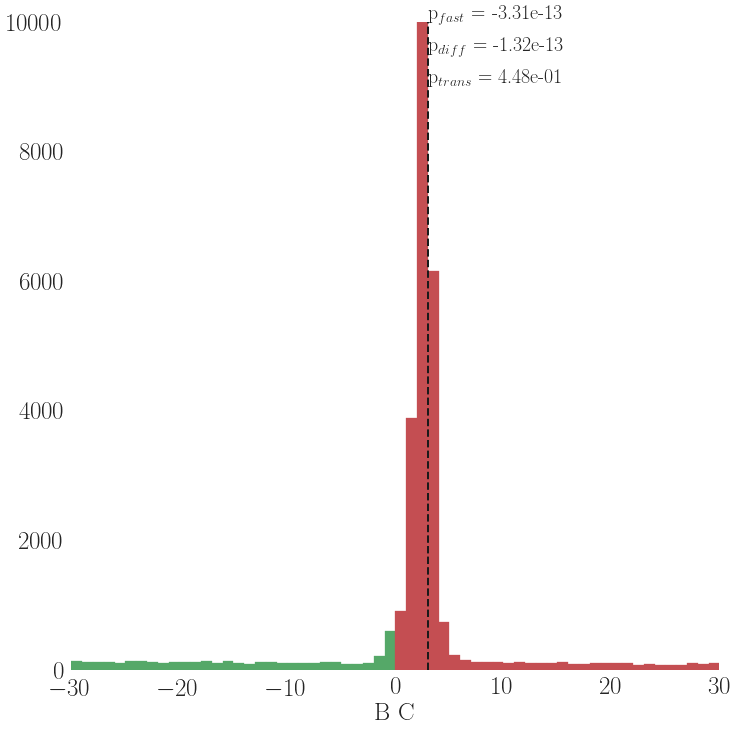

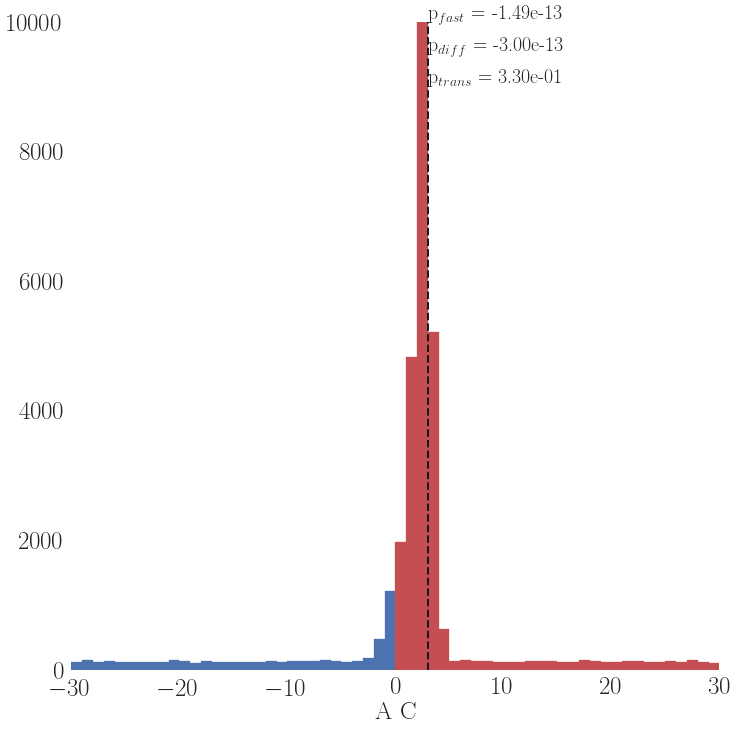

In [23]:
for idx, sl in enumerate([slice(1,3), slice(0,3,2)]):
    pcausal, pfast, bins, cch, cch_s = ccg_significance(*spiketrains_ABC[sl], binsize, time_limit, 
                                            hollow_fraction=.6, width=10)
    
    _, _ = plot_xcorr(spiketrains_ABC[sl], colors=colors[sl], time_limit=time_limit, 
                            binsize=binsize, acorr=False, ylim=ylim, density=False,
                            names=names[sl]);
    ax = plt.gca()
    mask = (bins >= latency) & (bins <= latency + winsize)
    m = np.max(cch[mask])
    print(m)
    pmin = pcausal[cch == m]
    trans_prob = sum(cch[mask] - cch_s[mask]) / len(spiketrains_ABC[sl][0])
    plt.plot([bins[pcausal==pmin][0], bins[pcausal==pmin][0]], 
             [0, m], ls='--', c='k')
    plt.annotate('p$_{{fast}}$ = {:.2e}'.format(pfast[cch == m][0]), 
                 [bins[pcausal == pmin][0], ylim[1]])
    plt.annotate('p$_{{diff}}$ = {:.2e}'.format(pcausal[cch == m][0]), 
                 [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.05])
    plt.annotate('p$_{{trans}}$ = {:.2e}'.format(trans_prob), 
                 [bins[pcausal == pmin][0], ylim[1] - ylim[1]*.1])
    ax.set_aspect(time_limit * 2 / ylim[1])
    ax.set_position([0, 0, 1, 1])
    sns.despine(bottom=True, left=True)

# graveyard

In [407]:
a = np.zeros((4,5))
a[range(len(a)),[1,2,3,4]] = 1
a

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [252]:

# senders_with_spikes = np.unique(data['spiketrains']['ex']['senders'])


# all_sources = np.array([
#     n for n in data['stim_nodes']['ex']
#     if n in senders_with_spikes]) # if had spikes

# all_targets = np.array([
#     n for n in data['nodes']['ex']
#     if (n not in all_sources and n in senders_with_spikes)])

# idx_s = np.random.randint(0, len(all_sources), int(N / 2))
# idx_t = np.random.randint(0, len(all_targets), int(N / 2))

# sources, targets = all_sources[idx_s], all_targets[idx_t]